In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import matplotlib.pyplot as plt
import warnings
from hdfs import InsecureClient
warnings.filterwarnings("ignore")
import os
import seaborn as sns
from scipy.stats import ttest_ind
# from imblearn.over_sampling import SMOTE
# import xgboost as xgb
import re
from sklearn.linear_model import LogisticRegression
# import statsmodels.api as sm
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
import _pickle as cPickle
import joblib

In [2]:
woe_path = 'woe_ftu_v1'
model_path = 'saved_model/model_ftu_v1'
weights_path = './weights_ftu_v1'
scaler_filename = 'scalar_ftu_v1'

In [5]:
sale_data = pd.read_csv('sale_bau_dates.csv')
sale_data['sale_bau'] = np.where(sale_data['sale_bau'].isin(['BAU','Aggressive BAU','Normal BAU','Sub-normal BAU']),0,1)
sale_data = sale_data.rename(columns={'sale_bau':'sale_day'})
sale_data


,date,sale_day
0,01-Sep-21,0
1,02-Sep-21,0
2,03-Sep-21,1
3,04-Sep-21,1
4,05-Sep-21,1
...,...,...
329,27-Jul-22,0
330,28-Jul-22,0
331,29-Jul-22,0
332,30-Jul-22,0


In [474]:
# url = "/user/dataplatform/indicium/temp/Propensity_31May_train_new/part-00000"
# hdfs_endpoint = "http://10.65.31.100:50070"
# client_hdfs = InsecureClient(hdfs_endpoint)
# with client_hdfs.read(url, encoding = 'utf-8') as reader:
#     iter_csv = pd.read_csv(reader)
# data = iter_csv.copy()
# data.to_csv('ftu_train_may.csv',index=False)

In [80]:
url = "/user/dataplatform/indicium/temp/Propensity_31MARCH_TRAIN_Final/part-00000"
hdfs_endpoint = "http://10.65.31.100:50070"
client_hdfs = InsecureClient(hdfs_endpoint)
with client_hdfs.read(url, encoding = 'utf-8') as reader:
    iter_csv = pd.read_csv(reader)
data = iter_csv.copy()
data

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date
0,2022-03-01 00:00:00.0,035d8c2b73781433,Other Marketing Channels,not_logged_in,30.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30,30.0,0,30.0,NaN
1,2022-03-01 00:00:00.0,036ada60ea304ecc,FB Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,2.0,2,30.0,NaN
2,2022-03-01 00:00:00.0,054e9c989126660f,FB Channel,not_logged_in,NaN,30.0,24.0,NaN,NaN,NaN,NaN,NaN,30,28.0,3,30.0,NaN
3,2022-03-01 00:00:00.0,060f3106ce3f136b,Non-Marketing,not_logged_in,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,30,21.0,0,21.0,NaN
4,2022-03-01 00:00:00.0,0657b012a9d685d7,FB Channel,not_logged_in,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,30,14.0,0,30.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600370,2022-03-31 00:00:00.0,fd6bb39c86831fca,Google Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FB Channel,0,0.0,19,0.0,2022-04-04
4600371,2022-03-31 00:00:00.0,fd6bb39c86831fca,Google Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google Channel,0,0.0,19,0.0,2022-03-31
4600372,2022-03-31 00:00:00.0,fdf1b3e0c73bd38c,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,5,0.0,NaN
4600373,2022-03-31 00:00:00.0,ff1e2a1e19a92a3f,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,3,NaN,NaN


In [81]:
data['installDate'] = pd.to_datetime(data['installDate'],infer_datetime_format=True)

In [82]:
data['deviceId'].nunique()

3350580

In [83]:
data.columns

Index(['installDate', 'deviceId', 'installChannel', 'install_FTU_Flag',
       'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits',
       'last3DaysDistinctPogs', 'last3DaysTotPogs', 'last3DaysSearchEvents',
       'organicLast3DaysVisits', 'orderChannel', 'Days_Since_Install',
       'Days_since_last_visit', 'Last_3Days_Visits',
       'Days_To_Last_Organic_Vist', 'First_Order_Date'],
      dtype='object')

In [84]:
data = data.drop_duplicates(subset=['deviceId','installDate'],keep='first')

In [85]:
sale_data['date'] = pd.to_datetime(sale_data['date'],infer_datetime_format=True)
data = pd.merge(data, sale_data.rename(columns={'date':'installDate'}), on='installDate', how='left')
data = data.rename(columns={'sale_day':'installed_on_sale_day'})

In [86]:
data

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date,installed_on_sale_day
0,2022-03-01,035d8c2b73781433,Other Marketing Channels,not_logged_in,30.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30,30.0,0,30.0,NaN,0
1,2022-03-01,036ada60ea304ecc,FB Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,2.0,2,30.0,NaN,0
2,2022-03-01,054e9c989126660f,FB Channel,not_logged_in,NaN,30.0,24.0,NaN,NaN,NaN,NaN,NaN,30,28.0,3,30.0,NaN,0
3,2022-03-01,060f3106ce3f136b,Non-Marketing,not_logged_in,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,30,21.0,0,21.0,NaN,0
4,2022-03-01,0657b012a9d685d7,FB Channel,not_logged_in,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,30,14.0,0,30.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350749,2022-03-31,fd215c3a24d2efc3,FB Channel,not_logged_in,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0.0,NaN,0
3350750,2022-03-31,fd6bb39c86831fca,Google Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FB Channel,0,0.0,19,0.0,2022-04-04,0
3350751,2022-03-31,fdf1b3e0c73bd38c,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,5,0.0,NaN,0
3350752,2022-03-31,ff1e2a1e19a92a3f,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,3,NaN,NaN,0


In [87]:
data['Days_since_last_visit'].value_counts()

0.0     347060
1.0     246673
2.0     204361
3.0     171659
4.0     148283
6.0     139316
5.0     138723
7.0     113223
8.0     109444
9.0     102449
10.0     96701
11.0     93310
12.0     83270
18.0     81470
17.0     80197
16.0     80059
14.0     75985
13.0     75395
19.0     74000
15.0     73987
20.0     72044
23.0     70695
22.0     69370
24.0     66704
21.0     65900
25.0     65202
26.0     54961
27.0     50001
28.0     49475
29.0     44256
30.0     38391
Name: Days_since_last_visit, dtype: int64

In [88]:
install_base = data[(data['installDate']>=datetime(2022,3,1)) & (data['installDate']<=datetime(2022,3,31))].shape[0]

In [89]:
print('customers who installed the app in May 2022 : '+str(install_base))

customers who installed the app in May 2022 : 3350754


In [90]:
# ## only keep users with visits in last 15 days
data = data[data['Days_since_last_visit']<=15]
data

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date,installed_on_sale_day
1,2022-03-01,036ada60ea304ecc,FB Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,2.0,2,30.0,NaN,0
4,2022-03-01,0657b012a9d685d7,FB Channel,not_logged_in,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,30,14.0,0,30.0,NaN,0
5,2022-03-01,06588b89e0ce7b5f,Google Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,1.0,5,NaN,NaN,0
10,2022-03-01,0a2c92aacc720d1d,FB Channel,not_logged_in,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,30,0.0,2,NaN,NaN,0
14,2022-03-01,0b9e75e02fb86c71,Google Channel,FTU,15.0,NaN,8.0,NaN,NaN,NaN,1.0,Google Channel,30,10.0,3,10.0,2022-03-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350747,2022-03-31,fbcb823ffd42c416,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,NaN,NaN,0
3350749,2022-03-31,fd215c3a24d2efc3,FB Channel,not_logged_in,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0.0,NaN,0
3350750,2022-03-31,fd6bb39c86831fca,Google Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FB Channel,0,0.0,19,0.0,2022-04-04,0
3350751,2022-03-31,fdf1b3e0c73bd38c,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,5,0.0,NaN,0


In [91]:
data['First_Order_Date'] = pd.to_datetime(data['First_Order_Date'],infer_datetime_format=True)
data['installDate'] = pd.to_datetime(data['installDate'],infer_datetime_format=True)

In [92]:
print('customers who installed the app in last month and visited in last 15 days : '+str(data.shape[0]))


customers who installed the app in last month and visited in last 15 days : 2219839


In [93]:
## check for orders before install date
t = data[['installDate','First_Order_Date']]
t = t.dropna(subset=['First_Order_Date'])
t['flag'] = np.where(t['installDate']>t['First_Order_Date'],1,0)
t['flag'].sum()

0

In [94]:
train = data[(data['First_Order_Date']>datetime(2022,3,31)) | (data['First_Order_Date'].isna())]
train

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date,installed_on_sale_day
1,2022-03-01,036ada60ea304ecc,FB Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,2.0,2,30.0,NaT,0
4,2022-03-01,0657b012a9d685d7,FB Channel,not_logged_in,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,30,14.0,0,30.0,NaT,0
5,2022-03-01,06588b89e0ce7b5f,Google Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,1.0,5,NaN,NaT,0
10,2022-03-01,0a2c92aacc720d1d,FB Channel,not_logged_in,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,30,0.0,2,NaN,NaT,0
15,2022-03-01,0c81898c2bcaf52a,Non-Marketing,No_order,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,30,6.0,1,6.0,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350747,2022-03-31,fbcb823ffd42c416,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,NaN,NaT,0
3350749,2022-03-31,fd215c3a24d2efc3,FB Channel,not_logged_in,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0.0,NaT,0
3350750,2022-03-31,fd6bb39c86831fca,Google Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FB Channel,0,0.0,19,0.0,2022-04-04,0
3350751,2022-03-31,fdf1b3e0c73bd38c,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,5,0.0,NaT,0


In [95]:
train['install_FTU_Flag'] = train['install_FTU_Flag'].replace('No_order','FTU')

In [96]:
train = train.rename(columns={'Days_since_last_visit':'Days_Since_Last_Visit','Days_To_Last_Organic_Vist':'Days_Since_Last_Organic_Vist'})
train


,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_Since_Last_Visit,Last_3Days_Visits,Days_Since_Last_Organic_Vist,First_Order_Date,installed_on_sale_day
1,2022-03-01,036ada60ea304ecc,FB Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,2.0,2,30.0,NaT,0
4,2022-03-01,0657b012a9d685d7,FB Channel,not_logged_in,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,30,14.0,0,30.0,NaT,0
5,2022-03-01,06588b89e0ce7b5f,Google Channel,not_logged_in,25.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,30,1.0,5,NaN,NaT,0
10,2022-03-01,0a2c92aacc720d1d,FB Channel,not_logged_in,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,30,0.0,2,NaN,NaT,0
15,2022-03-01,0c81898c2bcaf52a,Non-Marketing,FTU,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,30,6.0,1,6.0,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350747,2022-03-31,fbcb823ffd42c416,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,NaN,NaT,0
3350749,2022-03-31,fd215c3a24d2efc3,FB Channel,not_logged_in,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0.0,NaT,0
3350750,2022-03-31,fd6bb39c86831fca,Google Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FB Channel,0,0.0,19,0.0,2022-04-04,0
3350751,2022-03-31,fdf1b3e0c73bd38c,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,5,0.0,NaT,0


In [97]:
# train['target'] = np.where(((train['First_Order_Date']>=datetime(2022,6,1)) 
#                             & (train['First_Order_Date']<=datetime(2022,6,3))),1,0)

In [98]:
train['target'] = np.where(((train['First_Order_Date']>=datetime(2022,4,1)) 
                            & (train['First_Order_Date']<=datetime(2022,4,3))),1,
                              (np.where(train['First_Order_Date'].isna(),0,2)))
train = train[train['target']!=2]

In [99]:
train['target'].value_counts()

0    1605765
1      26645
Name: target, dtype: int64

In [100]:
install_to_order = train[['installDate','First_Order_Date']]
install_to_order = install_to_order.dropna(subset=['First_Order_Date'])
install_to_order['installDate'] = pd.to_datetime(install_to_order['installDate'],infer_datetime_format=True)
install_to_order['First_Order_Date'] = pd.to_datetime(install_to_order['First_Order_Date'],infer_datetime_format=True)
install_to_order['install_to_order'] = (install_to_order['First_Order_Date']-install_to_order['installDate']).dt.days
install_to_order['bucket'] = pd.cut(install_to_order['install_to_order'],bins=20)
install_to_order = install_to_order.groupby(['bucket']).agg({'install_to_order':'count'}).reset_index()
install_to_order['per'] = install_to_order['install_to_order']*100/install_to_order['install_to_order'].sum()
install_to_order['cum_per'] = install_to_order['per'].cumsum()
install_to_order

,bucket,install_to_order,per,cum_per
0,"(0.968, 2.6]",3912,14.681929,14.681929
1,"(2.6, 4.2]",4289,16.096829,30.778758
2,"(4.2, 5.8]",1562,5.862263,36.641021
3,"(5.8, 7.4]",2902,10.891349,47.532370
4,"(7.4, 9.0]",2314,8.684556,56.216926
5,"(9.0, 10.6]",993,3.726778,59.943704
6,"(10.6, 12.2]",1801,6.759242,66.702946
7,"(12.2, 13.8]",761,2.856071,69.559017
8,"(13.8, 15.4]",1241,4.657534,74.216551
9,"(15.4, 17.0]",1087,4.079565,78.296116


In [101]:
train['target'].value_counts()

0    1605765
1      26645
Name: target, dtype: int64

In [102]:
train[train['First_Order_Date']>datetime(2022,4,3)]['target'].sum()

0

In [103]:
train[train['First_Order_Date'].isna()]['target'].sum()

0

In [104]:
print('customers who installed the app in last month and visited in last 15 days and did not place first order in last month : '+str(train.shape[0]))


customers who installed the app in last month and visited in last 15 days and did not place first order in last month : 1632410


In [105]:
print('customers who ordered in next 3 days : '+str(train[train['target']==1].shape[0]))
print('customers who did not order in next 3 days : '+str(train[train['target']==0].shape[0]))

customers who ordered in next 3 days : 26645
customers who did not order in next 3 days : 1605765


In [106]:
print('base conversion rate : '+str(train[train['target']==1].shape[0]*100/train.shape[0]))

base conversion rate : 1.6322492511072586


In [107]:
train['installed_on_sale_day'].value_counts()

0    1154355
1     478055
Name: installed_on_sale_day, dtype: int64

In [108]:
categorical_cols = ['installChannel','install_FTU_Flag','installed_on_sale_day']
numerical_cols = ['daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits',
       'last3DaysDistinctPogs', 'last3DaysTotPogs', 'last3DaysSearchEvents',
       'organicLast3DaysVisits', 'Days_Since_Install', 'Days_Since_Last_Visit',
       'Last_3Days_Visits', 'Days_Since_Last_Organic_Vist']

In [109]:
train.columns

Index(['installDate', 'deviceId', 'installChannel', 'install_FTU_Flag',
       'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits',
       'last3DaysDistinctPogs', 'last3DaysTotPogs', 'last3DaysSearchEvents',
       'organicLast3DaysVisits', 'orderChannel', 'Days_Since_Install',
       'Days_Since_Last_Visit', 'Last_3Days_Visits',
       'Days_Since_Last_Organic_Vist', 'First_Order_Date',
       'installed_on_sale_day', 'target'],
      dtype='object')

In [110]:
n1 = train[train['target']==1]
n2 = train[train['target']==0]

In [111]:
## class balance
print('1 : '+str(round(n1.shape[0]*100/train.shape[0],2)))
print('0 : '+str(round(n2.shape[0]*100/train.shape[0],2)))

1 : 1.63
0 : 98.37


In [115]:
train.drop(['orderChannel'],axis=1,inplace=True)

In [116]:
pd.DataFrame(train.isna().sum())

,0
installDate,0
deviceId,0
installChannel,0
install_FTU_Flag,0
daysSinceLastSearch,732858
daysSinceLastATC,1385765
daysBetweenLast2Visits,481445
last3DaysDistinctPogs,1257654
last3DaysTotPogs,1257654
last3DaysSearchEvents,1485854


In [113]:
## EDA ##

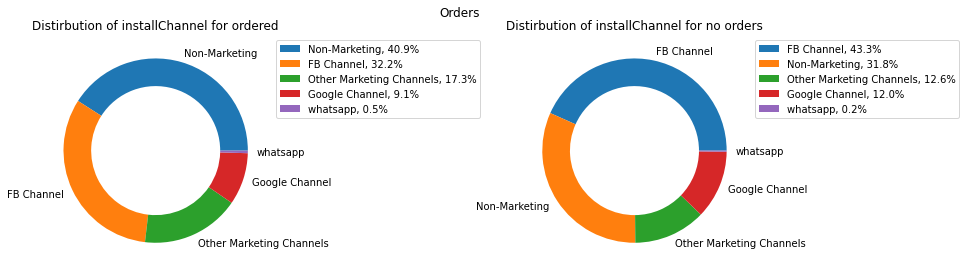

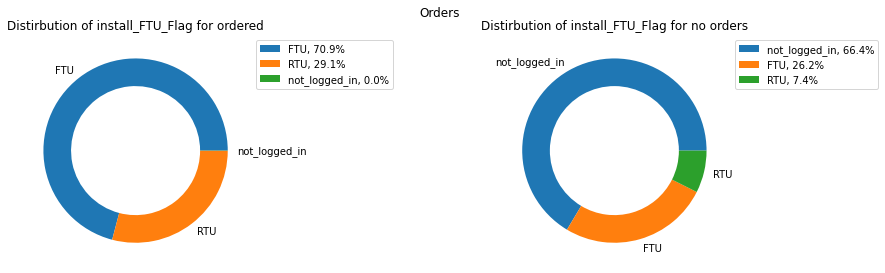

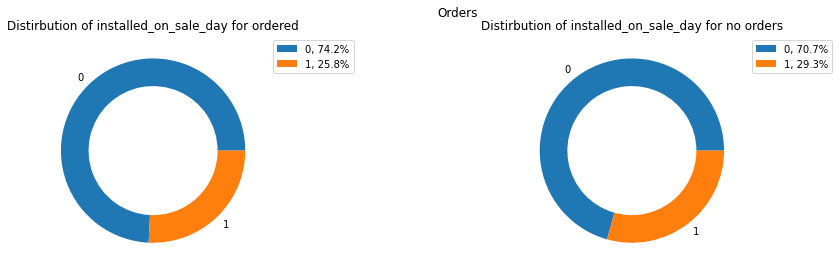

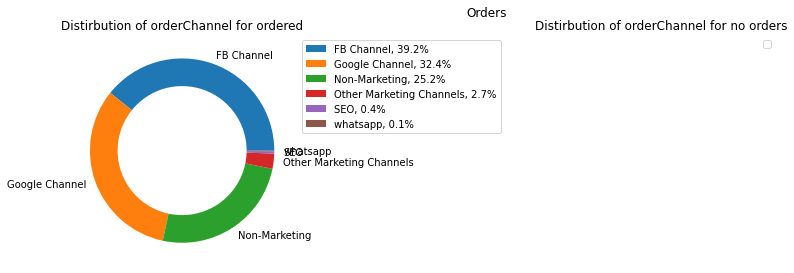

In [71]:
for column_name in categorical_cols:
    col = column_name
    fig,(ax1,ax2) = plt.subplots(1,2)
    df = train.copy()
    df = df[df['target']==1]
    t = pd.DataFrame(df[col].value_counts()).reset_index()
    t.columns = ['label','freq']
    t['freq'] = t['freq']*100/t['freq'].sum()
    ax1.pie(t['freq'], labels = t['label'], wedgeprops=dict(width=.3))
    labels = [f'{l}, {s:0.1f}%' for l, s in zip(t['label'], t['freq'])]
    ax1.legend(t['label'],labels=labels,loc='best',bbox_to_anchor=(1,1))
    ax1.set_title('Distirbution of '+str(col)+' for ordered')
    df = train.copy()
    df = df[df['target']==0]
    t = pd.DataFrame(df[col].value_counts()).reset_index()
    t.columns = ['label','freq']
    t['freq'] = t['freq']*100/t['freq'].sum()
    ax2.pie(t['freq'], labels = t['label'], wedgeprops=dict(width=.3))
    labels = [f'{l}, {s:0.1f}%' for l, s in zip(t['label'], t['freq'])]
    ax2.legend(t['label'],labels=labels,loc='best',bbox_to_anchor=(1,1))
    ax2.set_title('Distirbution of '+str(col)+' for no orders')
    fig.suptitle('Orders',x=1.2,y=1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()

In [72]:
df = train.copy()
df = df[df['target']==1]
t = pd.DataFrame(df['install_FTU_Flag'].value_counts()).reset_index()
t.columns = ['label','freq']
t['freq'] = t['freq']*100/t['freq'].sum()
t

,label,freq
0,FTU,70.910114
1,RTU,29.052355
2,not_logged_in,0.037530


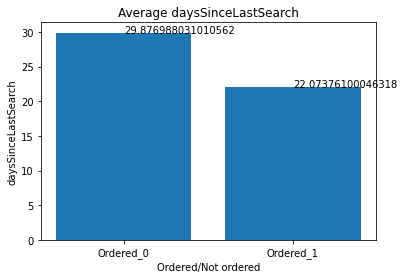

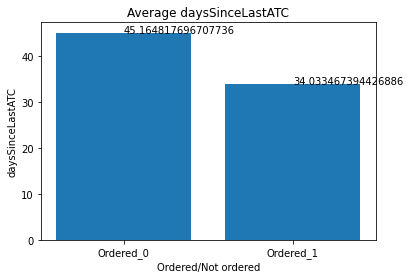

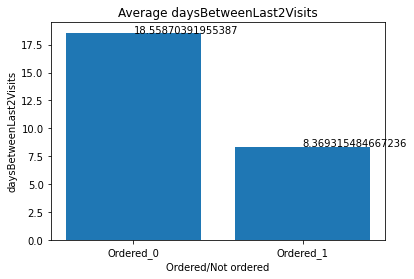

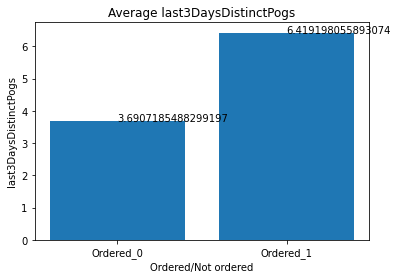

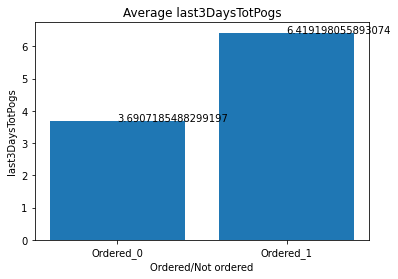

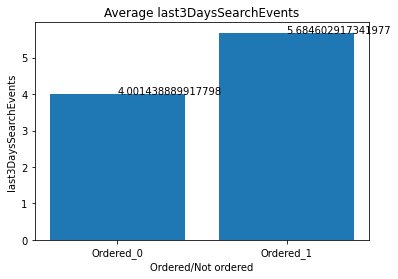

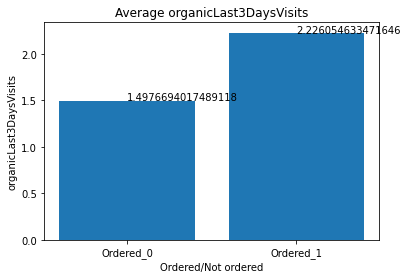

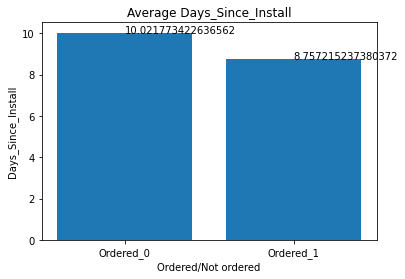

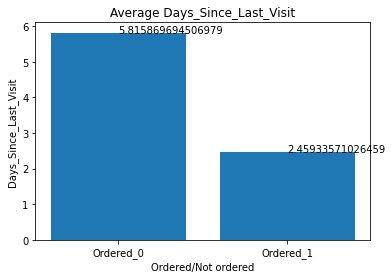

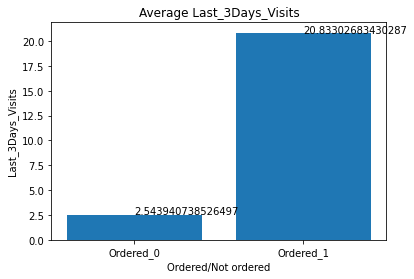

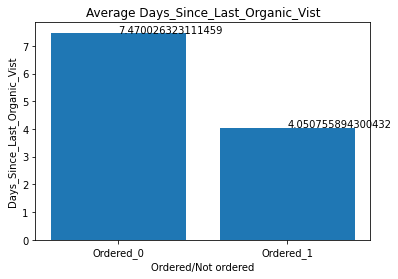

<Figure size 432x288 with 0 Axes>

In [73]:
for column_name in numerical_cols:
    col = column_name
    d = {'Ordered_0':'','Ordered_1':''}
    t = train.copy()
    t = t[t['target']==1]
    d['Ordered_1'] = t[col].mean()
    t = train.copy()
    t = t[t['target']==0]
    d['Ordered_0'] = t[col].mean()
    keys = list(d.keys())
    values = list(d.values())
    plt.bar(keys,values)
    for i, v in enumerate(values):
        plt.text(i,v,str(v))
    plt.xlabel("Ordered/Not ordered")
    plt.ylabel(str(col))
    plt.title("Average "+str(col))
    plt.show()
    plt.clf()

In [679]:
# values = [0,1]

# for col in numerical_cols:
#     for value in values:
#         subset = train[train['target'] == value]

#         # Draw the density plot
#         sns.distplot(subset[col], hist = True, kde = True,
#                      kde_kws = {'linewidth': 3},
#                      label = value)

#     # Plot formatting
#     plt.legend(prop={'size': 16}, title = 'Ordered')
#     plt.title('Density Plot for '+str(col))
#     plt.xlabel(col)
#     plt.ylabel('Density')
#     plt.show()
#     plt.clf()

In [680]:
# order_dist = pd.DataFrame(train['Days_to_firstOrder'].value_counts())
# order_dist = order_dist.reset_index()
# order_dist.columns = ['days_to_first_order','count']
# order_dist['%salience'] = order_dist['count']*100/order_dist['count'].sum()
# order_dist['salience_cum'] = order_dist['%salience'].cumsum()
# order_dist.head(20)

In [681]:
# train[['Last_3Days_Visits','Last_5Days_Visits','Last_7Days_Visits','Last_10Days_Visits','Last_15Days_Visits','Last_30Days_Visits']].corr()


In [682]:
# train[['Last_3Days_Distinct_Pogs','Last_5Days_Distinct_Pogs','Last_7Days_Distinct_Pogs','Last_10Days_Distinct_Pogs','Last_15Days_Distinct_Pogs','Last_30Days_Distinct_Pogs']].corr()


In [683]:
# train[['Last_3Days_Pogs','Last_5Days_Pogs','Last_7Days_Pogs','Last_10Days_Pogs','Last_15Days_Pogs','Last_30Days_Pogs']].corr()


In [684]:
# train[['searchEventsLast3Days','searchEventsLast5Days','searchEventsLast7Days','searchEventsLast10Days','searchEventsLast15Days','searchEventsLast30Days']].corr()


In [117]:
features = numerical_cols+categorical_cols
features.append('installDate')
features.append('deviceId')
X = train[features]
#X = pd.get_dummies(X,columns=categorical_cols,drop_first=True)
y = train['target']

In [118]:
def iv_variable(data, indep, dep):
    sub_data = data[[indep, dep]].copy()
    event = sub_data[dep].sum()
    non_event = sub_data.shape[0] - event
    iv_data = sub_data.groupby(indep).agg(['sum', 'size']).rename(columns = {'sum': 'event', 'size': 'total'})
    iv_data.columns = iv_data.columns.droplevel(level=0)
    iv_data = iv_data.reset_index(drop = False)
    iv_data['non_event'] = iv_data['total'] - iv_data['event'] 
    iv_data['per_event'] = iv_data['event']/event
    iv_data['per_non_event'] = iv_data['non_event']/non_event
    iv_data['woe'] = iv_data['woe'] = np.log(((iv_data['non_event'] + 0.5)/non_event)/((iv_data['event'] + 0.5)/event)) * (iv_data['per_non_event'] - iv_data['per_event'])
    iv_data['woe'] = 100*iv_data['woe']
    iv_data['cat_conversion'] = iv_data['event']/iv_data['total']
    base_conv = event/(event+non_event)
    iv_data['woe'] = np.where(iv_data['cat_conversion'] < base_conv, iv_data['woe']*(-1.0), iv_data['woe'])
    iv_data = iv_data[[indep, 'woe']]
    return(iv_data)


In [119]:
woe_dict = {}

for var in ['installChannel','install_FTU_Flag','installed_on_sale_day']:
    iv_var = iv_variable(train, var, 'target')
    woe_dict[var] = dict(zip(iv_var[var], iv_var['woe']))
    X = pd.merge(X, iv_var, how = 'left', on = var).drop(columns = [var]).rename(columns = {'woe': var})

In [120]:
f = open(woe_path,'wb')
cPickle.dump(woe_dict,f,-1)
f.close()

In [121]:
X = X.drop(['installDate'],axis=1)
X = X.set_index('deviceId')

In [122]:
pd.DataFrame(X.isna().sum())

,0
daysSinceLastSearch,732858
daysSinceLastATC,1385765
daysBetweenLast2Visits,481445
last3DaysDistinctPogs,1257654
last3DaysTotPogs,1257654
last3DaysSearchEvents,1485854
organicLast3DaysVisits,1283375
Days_Since_Install,0
Days_Since_Last_Visit,0
Last_3Days_Visits,0


In [123]:
fill_small = ['last3DaysDistinctPogs','last3DaysTotPogs','last3DaysSearchEvents','organicLast3DaysVisits',
              'Last_3Days_Visits']
X[fill_small] = X[fill_small].fillna(0)
fill_large = ['daysSinceLastSearch','daysSinceLastATC','daysBetweenLast2Visits','Days_Since_Install',
              'Days_Since_Last_Visit','Days_Since_Last_Organic_Vist']
X[fill_large] = X[fill_large].fillna(1000)
X.isna().sum()

daysSinceLastSearch             0
daysSinceLastATC                0
daysBetweenLast2Visits          0
last3DaysDistinctPogs           0
last3DaysTotPogs                0
last3DaysSearchEvents           0
organicLast3DaysVisits          0
Days_Since_Install              0
Days_Since_Last_Visit           0
Last_3Days_Visits               0
Days_Since_Last_Organic_Vist    0
installChannel                  0
install_FTU_Flag                0
installed_on_sale_day           0
dtype: int64

In [124]:
from sklearn.preprocessing import StandardScaler

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [127]:
features.remove('installDate')

In [128]:
features.remove('deviceId')

In [129]:
scalar = StandardScaler()
X_train[features] = scalar.fit_transform(X_train[features])
X_val[features] = scalar.transform(X_val[features])
X_test[features] = scalar.transform(X_test[features])

joblib.dump(scalar, scaler_filename) 

['scalar_ftu_v1']

In [130]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [131]:
print('total : '+str(y_train.shape[0]))
print('class 1 : '+str(y_train.sum()))
print('class 0 : '+str(y_train.shape[0]-y_train.sum()))

total : 1305928
class 1 : 21336
class 0 : 1284592


In [132]:
metrics = [keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.Accuracy(name='accuracy')]

2022-08-22 14:56:20.607085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 14:56:20.607172: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 14:56:20.607260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (datascience-whatsappmodels-3001): /proc/driver/nvidia/version does not exist
2022-08-22 14:56:20.607943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [133]:
def make_model(metrics=metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
    keras.layers.Dense(16, activation='relu',input_shape=(X_train.shape[-1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu',input_shape=(16,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias),
    ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    return model

In [134]:
y_train.sum()*100/len(y_train)

1.6337807291060458

In [135]:
initial_bias = np.log([y_train.sum()/len(y_train)])
initial_bias

array([-4.11427339])

In [136]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

1/1 [==============================] - 0s 223ms/step


array([[0.01590068],
       [0.01335154],
       [0.01701167],
       [0.01658642],
       [0.01824686],
       [0.01602948],
       [0.04004106],
       [0.02094646],
       [0.01863353],
       [0.0302312 ]], dtype=float32)

In [137]:
model.save_weights(weights_path)

In [138]:
BATCH_SIZE = 500
EPOCHS = 200

In [139]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [140]:
weight_for_0 = (1 / (len(y_train)-y_train.sum()) * (len(y_train) / 2.0))
weight_for_1 = (1 / y_train.sum()) * (len(y_train) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [141]:
class_weight

{0: 0.5083045823109594, 1: 30.603862017247845}

In [142]:
model = make_model()
model.load_weights(weights_path)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight)

Epoch 1/200
2612/2612 [==============================] - 9s 3ms/step - loss: 0.3731 - precision: 0.0980 - recall: 0.8076 - accuracy: 4.5025e-04 - val_loss: 0.2794 - val_precision: 0.1180 - val_recall: 0.9464 - val_accuracy: 2.8179e-04
Epoch 2/200
2612/2612 [==============================] - 8s 3ms/step - loss: 0.2569 - precision: 0.1117 - recall: 0.9116 - accuracy: 1.2788e-04 - val_loss: 0.2397 - val_precision: 0.1161 - val_recall: 0.9547 - val_accuracy: 1.8378e-05
Epoch 3/200
2612/2612 [==============================] - 8s 3ms/step - loss: 0.2394 - precision: 0.1099 - recall: 0.9359 - accuracy: 5.8962e-05 - val_loss: 0.2529 - val_precision: 0.1090 - val_recall: 0.9675 - val_accuracy: 1.8378e-05
Epoch 4/200
2612/2612 [==============================] - 8s 3ms/step - loss: 0.2333 - precision: 0.1073 - recall: 0.9455 - accuracy: 5.2070e-05 - val_loss: 0.2481 - val_precision: 0.1098 - val_recall: 0.9626 - val_accuracy: 0.0000e+00
Epoch 5/200
2612/2612 [==============================] - 8s 

In [143]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                240       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.save(model_path)

INFO:tensorflow:Assets written to: saved_model/model_ftu_v1/assets


In [145]:
## load model for inference
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                240       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [218]:
predicted_class = model.predict(X_test, batch_size=BATCH_SIZE).flatten()
predictions = pd.DataFrame(columns=['actual','predicted'])
predictions['actual'] = list(y_test)
predictions['predicted'] = list(predicted_class)
predictions['predicted_class'] = np.where(predictions['predicted']>0.5,1,0)

327/327 [==============================] - 0s 1ms/step


In [224]:
from sklearn import metrics

In [225]:

fpr, tpr, threshold = metrics.roc_curve(y_test, predicted_class)
roc_auc = metrics.auc(fpr, tpr)

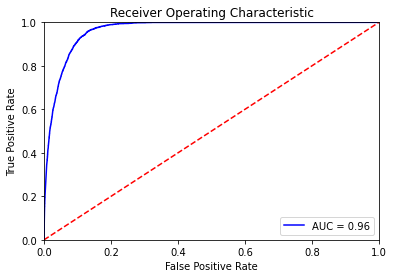

In [226]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

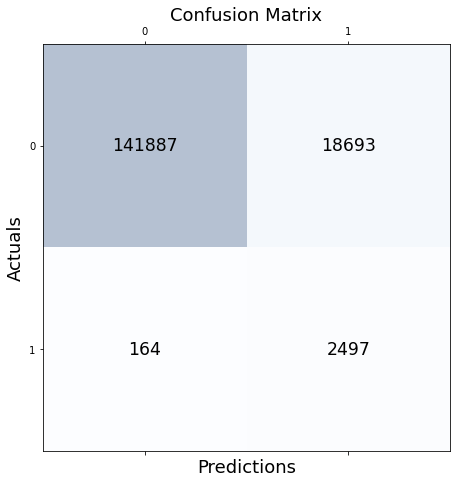

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=predictions['actual'], y_pred=predictions['predicted_class'])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [221]:
from sklearn.metrics import classification_report

In [149]:
print(classification_report(predictions['actual'],predictions['predicted_class']))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94    160580
           1       0.12      0.94      0.21      2661

    accuracy                           0.88    163241
   macro avg       0.56      0.91      0.57    163241
weighted avg       0.98      0.88      0.93    163241



In [150]:
## test data decile distribution
out_of_time = predictions[['actual','predicted']]
out_of_time = out_of_time.reset_index()
out_of_time['decile'] = pd.cut(out_of_time['predicted'], bins = np.arange(0,1.01, 0.1))
out = out_of_time.groupby(['decile'])['actual'].agg(['size', 'sum']).reset_index(drop = False).rename(columns = {'size': 'count', 'sum': 'orders'})
out['order_per'] = out['orders']*100/out['count']
out['salience'] = out['count']*100/out_of_time.shape[0]
out

,decile,count,orders,order_per,salience
0,"(0.0, 0.1]",113696,4,0.003518,69.649169
1,"(0.1, 0.2]",13104,19,0.144994,8.027395
2,"(0.2, 0.3]",7072,32,0.452489,4.332245
3,"(0.3, 0.4]",4571,40,0.875082,2.800154
4,"(0.4, 0.5]",3608,69,1.912417,2.210229
5,"(0.5, 0.6]",3323,85,2.557930,2.035641
6,"(0.6, 0.7]",3257,129,3.960700,1.995210
7,"(0.7, 0.8]",3907,235,6.014845,2.393394
8,"(0.8, 0.9]",4376,415,9.483547,2.680699
9,"(0.9, 1.0]",6327,1633,25.810021,3.875865


In [176]:
url = "/user/dataplatform/indicium/temp/Propensity_30April_Test_Final/part-00000"
hdfs_endpoint = "http://10.65.31.100:50070"
client_hdfs = InsecureClient(hdfs_endpoint)
with client_hdfs.read(url, encoding = 'utf-8') as reader:
    iter_csv = pd.read_csv(reader)
test = iter_csv.copy()
test

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date
0,2022-04-01 00:00:00.0,00cf89a836991a94,Other Marketing Channels,not_logged_in,16.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,29,15.0,1,16.0,NaN
1,2022-04-01 00:00:00.0,0169b7e7c10252b9,FB Channel,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,29.0,0,29.0,NaN
2,2022-04-01 00:00:00.0,0171ae1e66bfc160,Other Marketing Channels,not_logged_in,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,29,29.0,0,29.0,NaN
3,2022-04-01 00:00:00.0,0195b0ad054ea50f,FB Channel,FTU,26.0,NaN,1.0,NaN,NaN,NaN,NaN,FB Channel,29,16.0,0,16.0,2022-04-01
4,2022-04-01 00:00:00.0,021afb1ada80232b,FB Channel,not_logged_in,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,29,22.0,0,29.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062266,2022-04-30 00:00:00.0,f6ab6e5dd57156d9,Google Channel,No_order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1,NaN,NaN
5062267,2022-04-30 00:00:00.0,f6d73f4aa455e821,Non-Marketing,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0,NaN
5062268,2022-04-30 00:00:00.0,f8c8871dbb5c7458,Non-Marketing,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,17,0.0,NaN
5062269,2022-04-30 00:00:00.0,faf4de127d54b810,FB Channel,not_logged_in,581.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0.0,NaN


In [152]:
# test = pd.read_csv('ftu_test_june.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'ftu_test_june.csv'

In [177]:
test['installDate'] = pd.to_datetime(test['installDate'],infer_datetime_format=True)


In [178]:
test['deviceId'].nunique()

3891688

In [179]:
test.shape[0]

5062271

In [180]:
test = test.drop_duplicates(subset=['deviceId','installDate'],keep='first')
sale_data['date'] = pd.to_datetime(sale_data['date'],infer_datetime_format=True)
test = pd.merge(test, sale_data.rename(columns={'date':'installDate'}), on='installDate', how='left')
test = test.rename(columns={'sale_day':'installed_on_sale_day'})

In [181]:
test[['installed_on_sale_day']].isna().sum()

installed_on_sale_day    0
dtype: int64

In [182]:
install_base = test[(test['installDate']>=datetime(2022,6,1)) & (test['installDate']<=datetime(2022,6,30))].shape[0]
print('customers who installed the app in May 2022 : '+str(install_base))

customers who installed the app in May 2022 : 0


In [183]:
test = test[test['Days_since_last_visit']<=15]
test

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date,installed_on_sale_day
0,2022-04-01,00cf89a836991a94,Other Marketing Channels,not_logged_in,16.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,29,15.0,1,16.0,NaN,1
6,2022-04-01,03274b89c152f3b0,FB Channel,No_order,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,29,3.0,8,3.0,NaN,1
10,2022-04-01,054d3ca6e99e4109,Non-Marketing,not_logged_in,225.0,NaN,23.0,NaN,NaN,NaN,NaN,NaN,29,4.0,0,NaN,NaN,1
11,2022-04-01,05561b84507c6a70,Other Marketing Channels,RTU,26.0,NaN,9.0,NaN,NaN,NaN,NaN,Non-Marketing,29,0.0,38,21.0,2022-05-16,1
13,2022-04-01,0735334a8b5ec91a,FB Channel,not_logged_in,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,29,4.0,0,4.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891879,2022-04-30,f3131373d0ab6053,FB Channel,RTU,114.0,NaN,3.0,NaN,NaN,NaN,NaN,FB Channel,0,0.0,3,0.0,2022-04-30,1
3891880,2022-04-30,f47a8c24cbec5927,FB Channel,FTU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FB Channel,0,0.0,3,0.0,2022-04-30,1
3891882,2022-04-30,f6d73f4aa455e821,Non-Marketing,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0,NaN,1
3891883,2022-04-30,f8c8871dbb5c7458,Non-Marketing,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,17,0.0,NaN,1


In [184]:
test['First_Order_Date'] = pd.to_datetime(test['First_Order_Date'],infer_datetime_format=True)
test['installDate'] = pd.to_datetime(test['installDate'],infer_datetime_format=True)

print('customers who installed the app in last month and visited in last 15 days : '+str(test.shape[0]))

customers who installed the app in last month and visited in last 15 days : 2528697


In [185]:
## check for orders before install date
t = test[['installDate','First_Order_Date']]
t = t.dropna(subset=['First_Order_Date'])
t['flag'] = np.where(t['installDate']>t['First_Order_Date'],1,0)
t['flag'].sum()

0

In [186]:
test[(test['First_Order_Date']>datetime(2022,6,30)) | (test['First_Order_Date'].isna())]

,installDate,deviceId,installChannel,install_FTU_Flag,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,orderChannel,Days_Since_Install,Days_since_last_visit,Last_3Days_Visits,Days_To_Last_Organic_Vist,First_Order_Date,installed_on_sale_day
0,2022-04-01,00cf89a836991a94,Other Marketing Channels,not_logged_in,16.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,29,15.0,1,16.0,NaT,1
6,2022-04-01,03274b89c152f3b0,FB Channel,No_order,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,29,3.0,8,3.0,NaT,1
10,2022-04-01,054d3ca6e99e4109,Non-Marketing,not_logged_in,225.0,NaN,23.0,NaN,NaN,NaN,NaN,NaN,29,4.0,0,NaN,NaT,1
13,2022-04-01,0735334a8b5ec91a,FB Channel,not_logged_in,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,29,4.0,0,4.0,NaT,1
23,2022-04-01,0f543dab406d1a57,Non-Marketing,not_logged_in,2.0,NaN,0.0,1.0,1.0,3.0,2.0,NaN,29,2.0,1,2.0,NaT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891874,2022-04-30,ef6bec8258a356c2,Other Marketing Channels,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,2,0.0,NaT,1
3891875,2022-04-30,efa7649fb121d2c3,Google Channel,No_order,566.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0,NaT,1
3891882,2022-04-30,f6d73f4aa455e821,Non-Marketing,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0,NaT,1
3891883,2022-04-30,f8c8871dbb5c7458,Non-Marketing,not_logged_in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,17,0.0,NaT,1


In [187]:
test = test[(test['First_Order_Date']>datetime(2022,6,30)) | (test['First_Order_Date'].isna())]
test['install_FTU_Flag'] = test['install_FTU_Flag'].replace('No_order','FTU')
test = test.rename(columns={'Days_since_last_visit':'Days_Since_Last_Visit','Days_To_Last_Organic_Vist':'Days_Since_Last_Organic_Vist'})
# test['target'] = np.where(((test['First_Order_Date']>=datetime(2022,7,1)) 
#                             & (test['First_Order_Date']<=datetime(2022,7,3))),1,0)
test['target'] = np.where(((test['First_Order_Date']>=datetime(2022,7,1)) 
                            & (test['First_Order_Date']<=datetime(2022,7,3))),1,
                              (np.where(test['First_Order_Date'].isna(),0,2)))
test = test[test['target']!=2]
print('customers who installed the app in last month and visited in last 15 days and did not place first order in last month : '+str(test.shape[0]))
print('customers who ordered in next 3 days : '+str(test[test['target']==1].shape[0]))
print('customers who did not order in next 3 days : '+str(test[test['target']==0].shape[0]))
print('base conversion rate : '+str(test[test['target']==1].shape[0]*100/test.shape[0]))


customers who installed the app in last month and visited in last 15 days and did not place first order in last month : 1903664
customers who ordered in next 3 days : 4033
customers who did not order in next 3 days : 1899631
base conversion rate : 0.21185461299893257


In [188]:
features = numerical_cols+categorical_cols
features.append('installDate')
features.append('deviceId')
X = test[features]
y = test['target']

In [189]:
X = X.drop(['installDate'],axis=1)
X = X.set_index('deviceId')

In [190]:
features.remove('installDate')
features.remove('deviceId')

In [191]:
f = open(woe_path, 'rb')
woe_dict = cPickle.load(f)
f.close()

for var in woe_dict.keys():
    for key in woe_dict[var].keys():
        X[var] = X[var].replace(key,woe_dict[var][key])

In [192]:
fill_small = ['last3DaysDistinctPogs','last3DaysTotPogs','last3DaysSearchEvents','organicLast3DaysVisits',
              'Last_3Days_Visits']
X[fill_small] = X[fill_small].fillna(0)
X.isna().sum()

fill_large = ['daysSinceLastSearch','daysSinceLastATC','daysBetweenLast2Visits','Days_Since_Install',
              'Days_Since_Last_Visit','Days_Since_Last_Organic_Vist']
X[fill_large] = X[fill_large].fillna(1000)
X.isna().sum()

daysSinceLastSearch             0
daysSinceLastATC                0
daysBetweenLast2Visits          0
last3DaysDistinctPogs           0
last3DaysTotPogs                0
last3DaysSearchEvents           0
organicLast3DaysVisits          0
Days_Since_Install              0
Days_Since_Last_Visit           0
Last_3Days_Visits               0
Days_Since_Last_Organic_Vist    0
installChannel                  0
install_FTU_Flag                0
installed_on_sale_day           0
dtype: int64

In [193]:
scalar = joblib.load(scaler_filename) 
X[features] = scalar.transform(X[features])

In [194]:
X[features]

,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,last3DaysDistinctPogs,last3DaysTotPogs,last3DaysSearchEvents,organicLast3DaysVisits,Days_Since_Install,Days_Since_Last_Visit,Last_3Days_Visits,Days_Since_Last_Organic_Vist,installChannel,install_FTU_Flag,installed_on_sale_day
deviceId,,,,,,,,,,,,,,
00cf89a836991a94,-0.923725,-2.433182,-0.661695,-0.287514,-0.287514,-0.201541,-0.406191,2.459606,2.017793,-0.294128,-0.386155,0.808694,-0.728853,-1.55259
03274b89c152f3b0,1.099747,0.420123,-0.677215,-0.287514,-0.287514,-0.201541,-0.406191,2.459606,-0.602476,0.821726,-0.423411,-1.070982,1.384968,-1.55259
054d3ca6e99e4109,-0.493943,0.420123,-0.630654,-0.287514,-0.287514,-0.201541,-0.406191,2.459606,-0.384120,-0.453536,2.433802,1.147638,-0.728853,-1.55259
0735334a8b5ec91a,-0.948401,0.420123,-0.681649,-0.287514,-0.287514,-0.201541,-0.406191,2.459606,-0.384120,-0.453536,-0.420545,-1.070982,-0.728853,-1.55259
0f543dab406d1a57,-0.952514,0.420123,-0.681649,0.043270,0.043270,1.446181,2.082252,2.459606,-0.820832,-0.294128,-0.426277,1.147638,-0.728853,-1.55259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ef6bec8258a356c2,1.099747,0.420123,1.535533,-0.287514,-0.287514,-0.201541,-0.406191,-1.295459,-1.257544,-0.134721,-0.432008,0.808694,-0.728853,-1.55259
efa7649fb121d2c3,0.207281,0.420123,-0.679432,-0.287514,-0.287514,-0.201541,-0.406191,-1.295459,-1.257544,0.024687,-0.432008,-0.074998,1.384968,-1.55259
f6d73f4aa455e821,1.099747,0.420123,1.535533,-0.287514,-0.287514,-0.201541,-0.406191,-1.295459,-1.257544,0.024687,-0.432008,1.147638,-0.728853,-1.55259


In [206]:
predicted_class = model.predict(X[features], batch_size=BATCH_SIZE).flatten()
predictions = pd.DataFrame(columns=['actual','predicted'])
predictions['actual'] = list(y)
predictions['predicted'] = list(predicted_class)
predictions['predicted_class'] = np.where(predictions['predicted']>0.7,1,0)


3808/3808 [==============================] - 6s 1ms/step


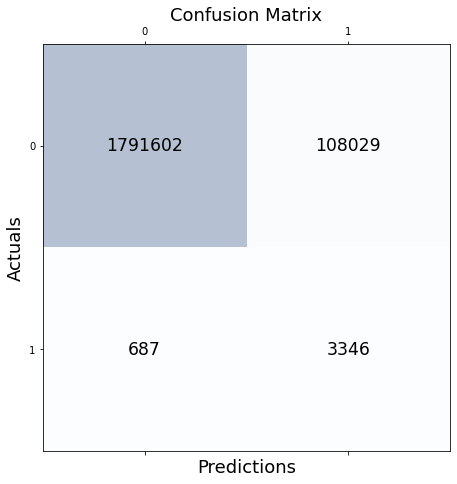

In [207]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=predictions['actual'], y_pred=predictions['predicted_class'])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [208]:
from sklearn.metrics import classification_report

print(classification_report(predictions['actual'],predictions['predicted_class']))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1899631
           1       0.03      0.83      0.06      4033

    accuracy                           0.94   1903664
   macro avg       0.51      0.89      0.51   1903664
weighted avg       1.00      0.94      0.97   1903664



In [205]:
## test data decile distribution
out_of_time = predictions[['actual','predicted']]
out_of_time = out_of_time.reset_index()
out_of_time['decile'] = pd.cut(out_of_time['predicted'], bins = np.arange(0,1.01, 0.1))
out = out_of_time.groupby(['decile'])['actual'].agg(['size', 'sum']).reset_index(drop = False).rename(columns = {'size': 'count', 'sum': 'orders'})
out['order_per'] = out['orders']*100/out['count']
out['salience'] = out['count']*100/out_of_time.shape[0]
out


,decile,count,orders,order_per,salience
0,"(0.0, 0.1]",1400231,9,0.000643,73.554524
1,"(0.1, 0.2]",162201,26,0.016029,8.520464
2,"(0.2, 0.3]",76399,58,0.075917,4.013261
3,"(0.3, 0.4]",49301,82,0.166325,2.589795
4,"(0.4, 0.5]",37730,90,0.238537,1.981967
5,"(0.5, 0.6]",33276,138,0.414713,1.747998
6,"(0.6, 0.7]",33151,284,0.856686,1.741431
7,"(0.7, 0.8]",36220,407,1.123689,1.902647
8,"(0.8, 0.9]",37299,687,1.841872,1.959327
9,"(0.9, 1.0]",37856,2252,5.948859,1.988586
